In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import sigma
from pycbc.noise import frequency_noise_from_psd
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import make_waveform, calculate_mode_snr, shifted_f, two_ecc_harms_SNR

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Generate single eccentric waveform as 'data'

In [2]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 4096
f_low = 20
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate TEOBResumS-Dali waveform
data_pars = {'ecc10sqrd': 0.2**2, 'chirp_mass': 32, 'symmetric_mass_ratio': 0.249, 'chi_eff': 0, 'distance': 3000}
df = 1/tlen
flen = (tlen*sample_rate)//2 + 1
raw_data = make_waveform(data_pars, df, f_low, flen, approximant='TEOBResumS-Dali')

sig = sigma(raw_data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psd['H1'].sample_frequencies[-1])
print(f'sigma: {sig}')

# Add gaussian noise
# data = {'H1': (raw_data + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
data = {'H1': (raw_data).to_timeseries()}

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sigma: 14.488400665693073


# Generate eccentric harmonics and match filter data

In [3]:
# Generate TEOBResumS-Dali waveform
harm_pars = {'ecc10sqrd': 0.2**2, 'chirp_mass': 32, 'symmetric_mass_ratio': 0.249, 'chi_eff': 0, 'distance': 1}
harm_dict = make_waveform(harm_pars, df, f_low, flen, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6)

# Match filter harmonics
harm_perp = {}
for key in harm_dict.keys():
    harm_perp[key] = harm_dict[key] / sigma(harm_dict[key], psd[ifos[0]], low_frequency_cutoff=f_low,
                                            high_frequency_cutoff=psd[ifos[0]].sample_frequencies[-1])
mode_SNRs, _ = calculate_mode_snr(data[ifos[0]], psd[ifos[0]], harm_perp, data[ifos[0]].sample_times[0],
                                  data[ifos[0]].sample_times[-1], f_low, harm_dict.keys(), dominant_mode=0)
for key in mode_SNRs.keys():
    print(f'rho_{key}: {np.abs(mode_SNRs[key]):.2f}, phi_{key}: {np.angle(mode_SNRs[key]):.2f}')

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:217: RuntimeWarning: divide by zero encountered in divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


rho_0: 14.08, phi_0: -0.87
rho_1: 2.23, phi_1: -2.19
rho_-1: 0.72, phi_-1: -1.85
rho_2: 0.30, phi_2: 2.92


# Test MA relation

In [4]:
# Calculate shifted frequencies
input_MAs = np.linspace(0, 2*np.pi, 10, endpoint=False)
q = 1/q_from_eta(data_pars['symmetric_mass_ratio'])
M = np.sum(component_masses_from_mchirp_q(data_pars['chirp_mass'], q))
s_f_2pi = f_low - shifted_f(f_low, data_pars['ecc10sqrd']**0.5, M, q)
s_fs = f_low - s_f_2pi*input_MAs/(2*np.pi)

# Calculate matches (and thus inferred mean anomaly)
infer_MA_1 = []
infer_MA_n1 = []
infer_MA_1n1 = []
for i, s_f in enumerate(s_fs):
    s = make_waveform(data_pars, df, s_f, flen, approximant='TEOBResumS-Dali').to_timeseries()
    z, _ = calculate_mode_snr(s, psd[ifos[0]], harm_perp, s.sample_times[0],
                                      s.sample_times[-1], f_low, harm_dict.keys(), dominant_mode=0)
    infer_MA_1.append((np.angle(z[1])-np.angle(z[0])) % (2*np.pi))
    infer_MA_n1.append((np.angle(z[0])-np.angle(z[-1])) % (2*np.pi))
    _, MA_1n1 = two_ecc_harms_SNR({k: np.abs(z[k]) for k in [0,1,-1]},
                                  {k: np.angle(z[k]) for k in [0,1,-1]})
    infer_MA_1n1.append(MA_1n1)
    print(f'\r{i+1} done out of {len(s_fs)}', end='')

10 done out of 10

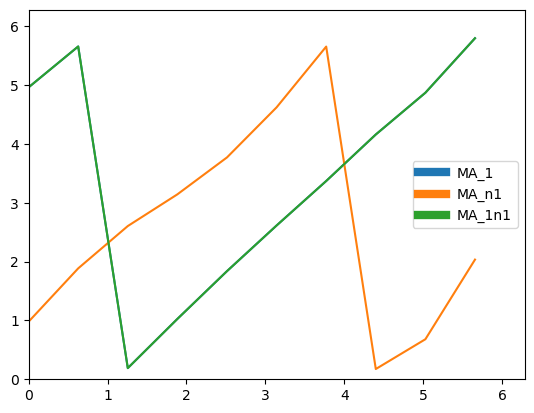

In [7]:
plt.plot(input_MAs, infer_MA_1, label='MA_1')
plt.plot(input_MAs, infer_MA_n1, label='MA_n1')
plt.plot(input_MAs, infer_MA_1n1, label='MA_1n1')
plt.legend()
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.show()